## Predicting Hospital Return Rates Using Data Science

This dataset contains information collected from five hospitals concerning patient information, including, but not limited to, arrival and departure data. Both the hospitals’ and patients’ details have been anonymized for privacy protection. The data was collected in order to identify patients who would need to be readmitted to the hospital within 30 days, which is relayed in the RETURN variable. If RETURN is 0, the patient did not need to return to the hospital within 30 days. If RETURN is 1, then the patient did return. The data is separated into two CSV files, one each for training and testing data.

In order to build models that could determine if patients would need to return to the hospital, I decided to use accuracy as our performance measure. While classifying a person who must return to the hospital is extremely important so he/she may receive the proper medical care he/she needs, it is also important to properly classify people who do not need to return to the hospital. Asking a healthy person to return to the hospital would not only be an inconvenience for the patient, but it would also cause unnecessary stress to the returning patient. This notebook includes exploratory analysis as well as implementation of machine learning models to understand the best method to correctly predict if a patient returns to the hospital or not 

### Importing Required Packages

In [1]:
# Importing required packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from dateutil.parser import parse

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
#import pydotplus

from sklearn.ensemble import RandomForestClassifier,BaggingClassifier

import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.colors import ListedColormap

from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

from numpy import loadtxt
from xgboost import XGBClassifier

In [2]:
train_data = pd.read_csv('Hospitals_Train.csv')
test_data  = pd.read_csv('Hospitals_Test_X.csv')
test_data_y = pd.read_csv('Hospitals_Test_Y_data.csv')

In [3]:
train_data.DC_RESULT.unique()

array(['Home or Self Care', 'LEFT W/O BEING SEEN BEFORE TRIAGE',
       'Home Health Care Svc',
       'Discharge to acute care (medical/surgical) hospital',
       'LEFT W/O BEING SEEN AFTER TRIAGE',
       'Not specified Other or Unknown', 'Expired', 'Rehab Facility',
       'Discharge to Juvenile/Adult Detention or Police Custody',
       'LEFT W/O COMPLETED TREATMENT', 'Left Against Medical Advice',
       'To this institution for OP services as specified by the disch plan of care - OP Only',
       'Psychiatric Unit or Psychiatric Hospital',
       'Discharged to Other Facility', 'Skilled Nursing Facility',
       'Left Prior to Exam', 'Discharge to Shelters',
       'Hospice/Medical Facility',
       'Discharge to Onsite Chronic From Acute',
       'Admitted as an Inpatient - OP Only',
       'To another institution for OP services as spec. by the disch plan of care - OP Only',
       'Hospice/Home',
       'Discharge to on-site distinct psychiatric unit from acute care - IP Only

In [4]:
def preprocess_data(input_df):
    input_df.set_index('INDEX', inplace=True) # setting INDEX as index
    columns = ['RACE','ETHNICITY','FINANCIAL_CLASS','ED_RESULT','ACUITY_ARR','DC_RESULT','ADMIT_RESULT','CONSULT_IN_ED',
               'RISK','SEVERITY']
    
    input_df['CHARGES'] = np.where(input_df['CHARGES']=='#VALUE!',np.nan,input_df['CHARGES'])
    input_df['CHARGES'] = input_df['CHARGES'].astype(float)
    input_df['CHARGES'].fillna((input_df['CHARGES'].mean()), inplace=True)
    
    for col in columns:
        if (col != 'CONSULT_IN_ED'):
            input_df[col] = input_df[col].replace(np.nan, 'Unknown', regex=True) # replacing NaNs with Unknown
        else:
            input_df[col] = input_df[col].replace(np.nan, 0, regex=True) # replacing NaNs with 0
            
    # getting top 10 DC_RESULT categories 
    top_dc_results= list(dict(input_df.groupby('DC_RESULT').agg('count')['HOSPITAL'].sort_values(ascending=False)[0:10]).keys())
    # classifying DC_RESULT into top 10 categories OR 'Other'
    input_df['DC_RESULT'] = pd.Series(np.where(input_df['DC_RESULT'].isin(top_dc_results), input_df['DC_RESULT'], 'Other'),input_df.index)
    
    # if month of arrival and month of departure are not same, then he has stayed for slightly longer
    input_df['LONGSTAY']  = np.where(input_df.MONTH_ARR != input_df.MONTH_DEP, 1, 0)
    
    # removing columns that are not useful
    input_df.drop(['WEEKDAY_ARR','WEEKDAY_DEP','HOUR_ARR','HOUR_DEP','MONTH_ARR','MONTH_ARR','MONTH_DEP'], axis=1, inplace=True)
    
    return input_df

In [5]:
df_train = preprocess_data(train_data) # pre-processing and getting new dataset
df_test  = preprocess_data(test_data) # pre-processing and getting new dataset

In [6]:
df_train = df_train.dropna(subset=['RETURN']) # dropping rows that have NaN for predictor variable RETURN
# Re-classifying RETURN into binary values
df_train['RETURN'] = pd.Series(np.where(df_train['RETURN'] == 'Yes', 1, 0),df_train.index) 

C:\Users\prave\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
test_data_y.set_index('INDEX', inplace=True) #getting test labels
test_data_y = test_data_y.dropna(subset=['RETURN']) # dropping rows that have NaN for predictor variable RETURN
test_data_y['RETURN'] = pd.Series(np.where(test_data_y['RETURN'] == 'Yes', 1, 0),test_data_y.index)
# Re-classifying RETURN into binary values

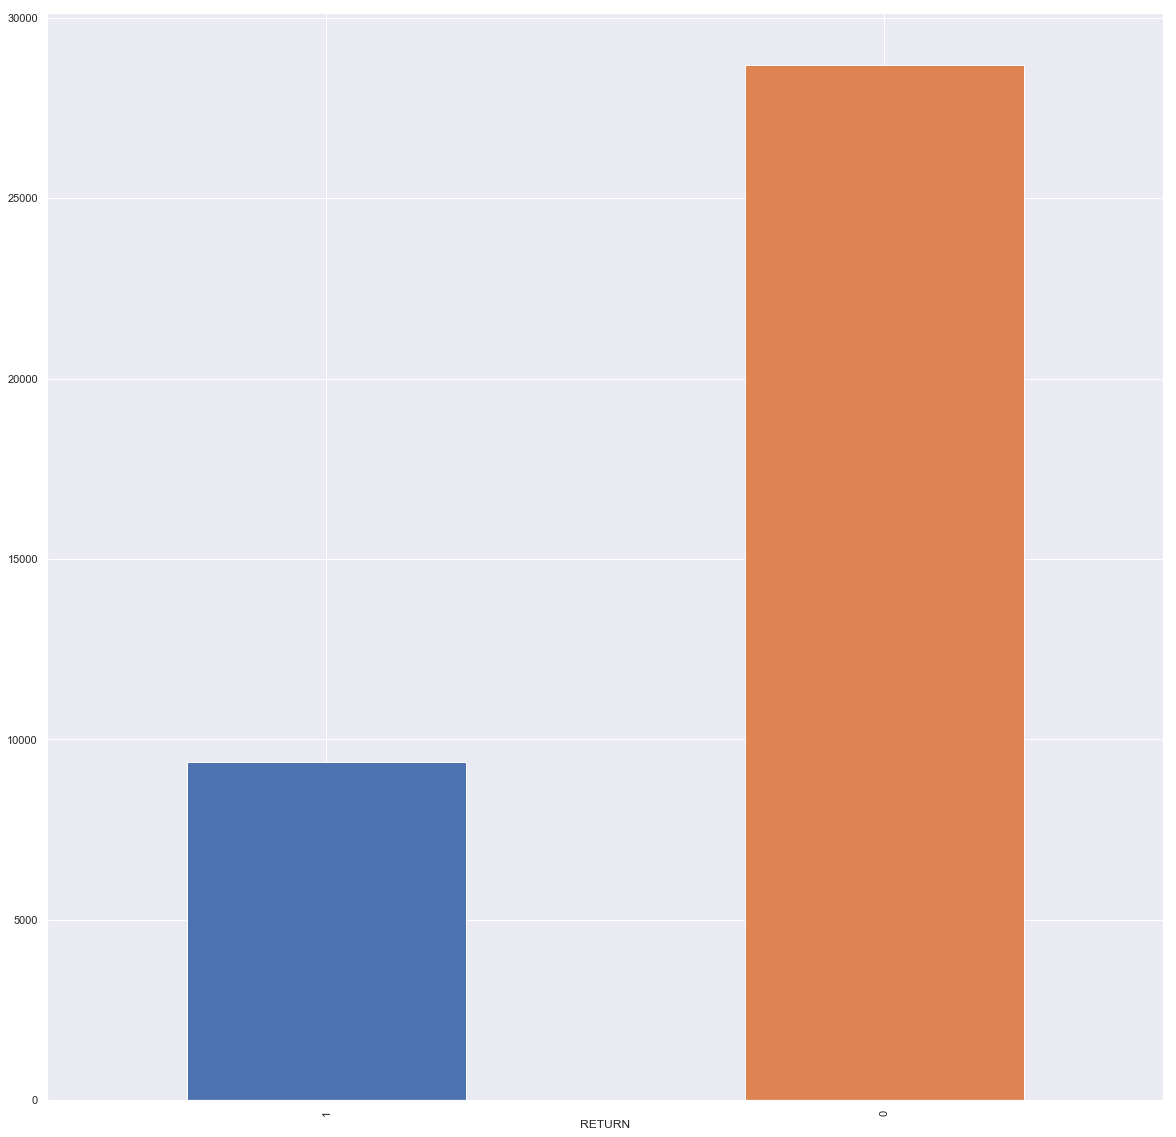

In [8]:
# Looking at distribution of RETURN in training set
sns.set(rc={'figure.figsize':(20,20)})
df_train.groupby('RETURN').agg('count')['HOSPITAL'].sort_values().plot(kind='bar')

In [9]:
df_train.groupby('RETURN').agg('count')['HOSPITAL'].sort_values()

RETURN
1     9384
0    28696
Name: HOSPITAL, dtype: int64

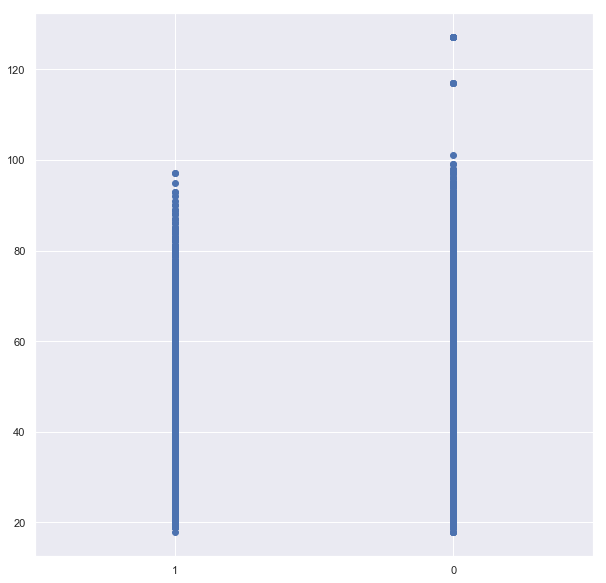

In [10]:
sns.set(rc={'figure.figsize':(10,10)})
plt.scatter(df_train['RETURN'].astype(str), df_train['AGE'])
plt.margins(x=0.5)
plt.show()

In [11]:
df_train

,HOSPITAL,GENDER,AGE,RACE,ETHNICITY,FINANCIAL_CLASS,SAME_DAY,ED_RESULT,ACUITY_ARR,DC_RESULT,...,CONSULT_ORDER,CONSULT_CHARGE,CONSULT_IN_ED,DIAGNOSIS,DIAG_DETAILS,RISK,SEVERITY,CHARGES,RETURN,LONGSTAY
INDEX,,,,,,,,,,,,,,,,,,,,,
1.0,Hospital C,Female,27.0,Black or African American,Not Hispanic or Latino,MA MCO,0.0,Admit,3-Urgent,Home or Self Care,...,0.0,0.0,0.0,Yes,4.0,Minor,Moderate,9709.43,1,0
2.0,Hospital E,Female,43.0,Black or African American,Not Hispanic or Latino,MA MCO,1.0,Left prior to completing treatment,3-Urgent,Home or Self Care,...,0.0,0.0,0.0,Yes,0.0,Unknown,Unknown,2371.55,0,0
3.0,Hospital E,Male,24.0,Black or African American,Not Hispanic or Latino,MA MCO,1.0,Discharge,4-Less Urgent,Home or Self Care,...,0.0,0.0,0.0,Yes,0.0,Unknown,Unknown,407.36,0,0
4.0,Hospital B,Female,24.0,Black or African American,Not Hispanic or Latino,MA MCO,1.0,Discharge,3-Urgent,Home or Self Care,...,0.0,0.0,0.0,Yes,0.0,Unknown,Unknown,3018.71,0,0
5.0,Hospital E,Male,31.0,Other,Hispanic or Latino,Commercial,1.0,Discharge,4-Less Urgent,Home or Self Care,...,0.0,0.0,0.0,Yes,0.0,Unknown,Unknown,1045.68,0,0
6.0,Hospital A,Female,34.0,Black or African American,Not Hispanic or Latino,MA MCO,0.0,Admit,3-Urgent,Home or Self Care,...,0.0,0.0,0.0,Yes,4.0,Major,Major,10429.38,0,0
7.0,Hospital C,Female,32.0,White,Not Hispanic or Latino,MA MCO,1.0,Discharge,4-Less Urgent,Home or Self Care,...,0.0,0.0,0.0,Yes,0.0,Unknown,Unknown,2404.37,0,0
8.0,Hospital D,Female,39.0,Black or African American,Not Hispanic or Latino,MA MCO,1.0,LWBS before Triage,3-Urgent,LEFT W/O BEING SEEN BEFORE TRIAGE,...,0.0,0.0,0.0,No,0.0,Unknown,Unknown,0.00,1,0
9.0,Hospital E,Male,54.0,Black or African American,Not Hispanic or Latino,Medicare Replacement Plan,1.0,Elopement,3-Urgent,Home or Self Care,...,0.0,0.0,0.0,No,0.0,Unknown,Unknown,187.53,0,0


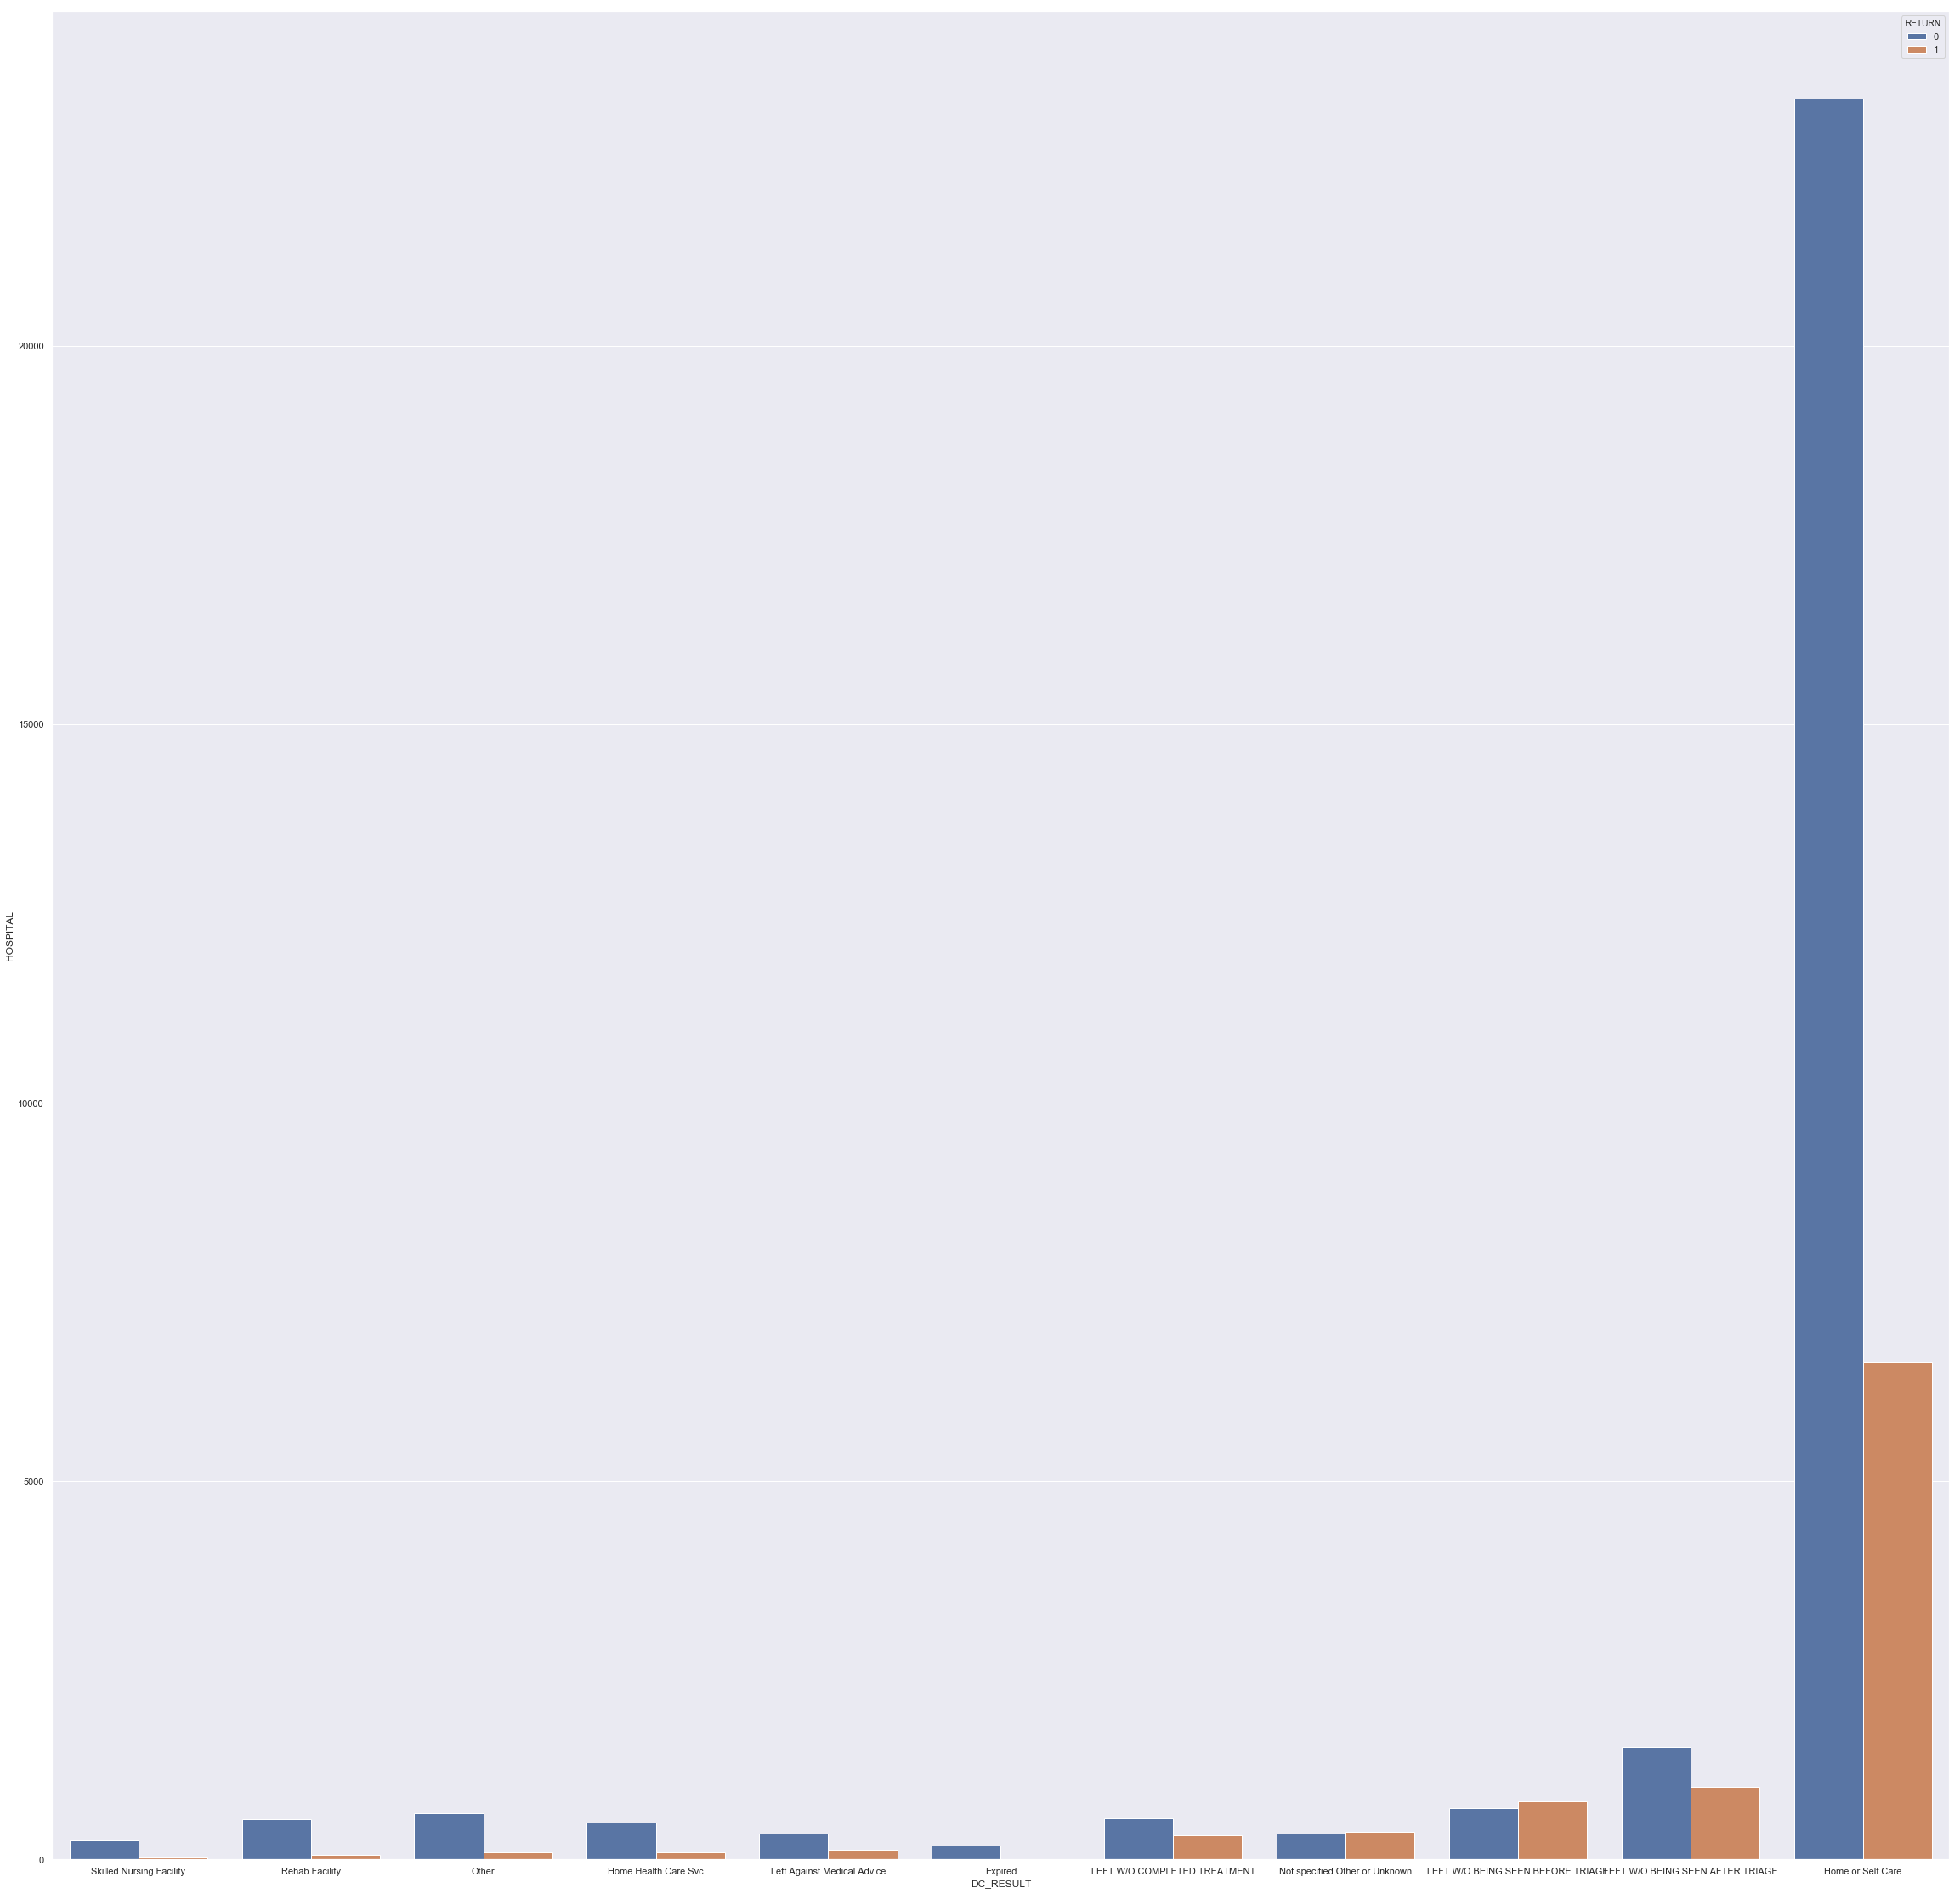

In [12]:
df_dc_result = pd.DataFrame(df_train.groupby(['DC_RESULT','RETURN']).agg('count')['HOSPITAL'].sort_values())
df_dc_result.reset_index(inplace=True)
sns.set(rc={'figure.figsize':(40,40)})
sns.barplot(x='DC_RESULT', y='HOSPITAL', hue='RETURN', data=df_dc_result)

### Machine Learning Models For Prediction

In [13]:
le = preprocessing.LabelEncoder()
for column_name in df_train.columns:
    if df_train[column_name].dtype == object:
        df_train[column_name] = le.fit_transform(df_train[column_name].astype(str))
        df_train[column_name] = df_train[column_name].astype('category')
    else:
        pass

C:\Users\prave\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
C:\Users\prave\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [14]:
le = preprocessing.LabelEncoder()
for column_name in df_test.columns:
    if df_test[column_name].dtype == object:
        df_test[column_name] = le.fit_transform(df_test[column_name].astype(str))
        df_test[column_name] = df_test[column_name].astype('category')
    else:
        pass

In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 38080 entries, 1.0 to 38221.0
Data columns (total 21 columns):
HOSPITAL           38080 non-null category
GENDER             38080 non-null category
AGE                38080 non-null float64
RACE               38080 non-null category
ETHNICITY          38080 non-null category
FINANCIAL_CLASS    38080 non-null category
SAME_DAY           38080 non-null float64
ED_RESULT          38080 non-null category
ACUITY_ARR         38080 non-null category
DC_RESULT          38080 non-null category
ADMIT_RESULT       38080 non-null category
CONSULT_ORDER      38080 non-null float64
CONSULT_CHARGE     38080 non-null float64
CONSULT_IN_ED      38080 non-null float64
DIAGNOSIS          38080 non-null category
DIAG_DETAILS       38080 non-null float64
RISK               38080 non-null category
SEVERITY           38080 non-null category
CHARGES            38080 non-null float64
RETURN             38080 non-null int32
LONGSTAY           38080 non-null i

In [16]:
X_train = df_train.loc[:, df_train.columns != 'RETURN']
y_train = df_train.loc[:, df_train.columns == 'RETURN']
X_test  = df_test.copy(deep = False)
y_test = test_data_y.copy(deep = False) 

### Logistic Regression

In [17]:
logit_model=sm.Logit(y_train,X_train.astype(float))
result=logit_model.fit()
print(result.summary2())

Optimization terminated successfully.
         Current function value: 0.531104
         Iterations 7
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.049     
Dependent Variable: RETURN           AIC:              40488.8896
Date:               2019-08-11 15:53 BIC:              40659.8385
No. Observations:   38080            Log-Likelihood:   -20224.   
Df Model:           19               LL-Null:          -21263.   
Df Residuals:       38060            LLR p-value:      0.0000    
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
HOSPITAL         -0.0070   0.0086  -0.8128 0.4163 -0.0238  0.0099
GENDER            0.6394   0.0253  25.2369 0.0000  0.5898  0.6891


In [18]:
y_pred = result.predict(X_test.astype(float))
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
s = "The AUC is "+str(auc(fpr,tpr))

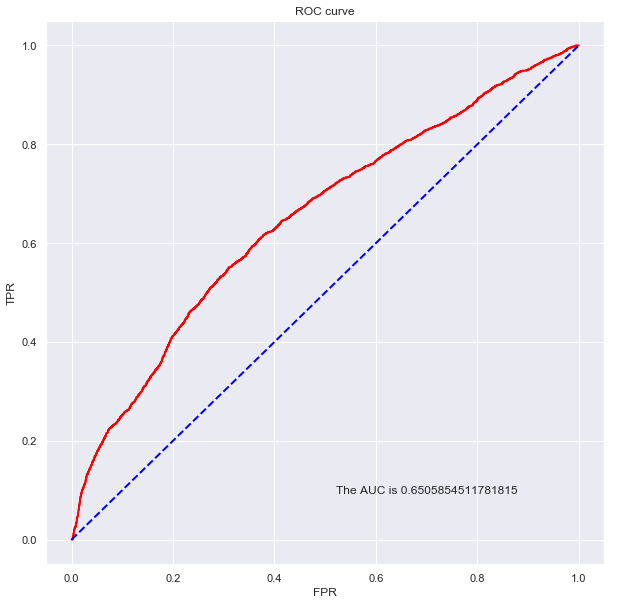

In [19]:
##Computing false and true positive rates
sns.set(rc={'figure.figsize':(10,10)})
plt.figure()
##Adding the ROC
plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.text(0.7, 0.1, s, horizontalalignment='center', verticalalignment='center')
plt.title('ROC curve')
plt.show()

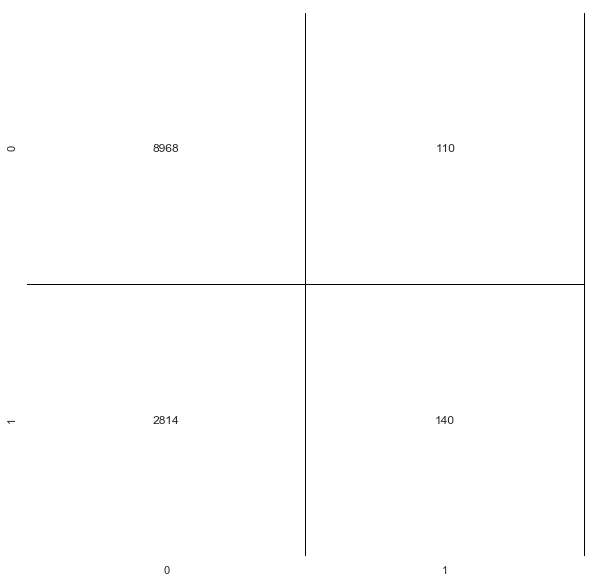

In [20]:
y_pred = [1 if x > 0.5 else 0 for x in y_pred]
confusion_matrix = confusion_matrix(y_test, y_pred)
with sns.axes_style('white'):
    sns.heatmap(confusion_matrix,
                cbar=False,
                linecolor='black',
                linewidth = 0.5,
                square=False,
                annot=True,
                fmt='g',
                cmap=ListedColormap(['white']),
                linewidths=0.5)

In [21]:
accuracy_logreg = ((confusion_matrix[0][0]+confusion_matrix[1][1])/np.sum(confusion_matrix))*100
print('Accuracy of logistic regression classifier on test set: {:.2f} %'.format(accuracy_logreg))

Accuracy of logistic regression classifier on test set: 75.70 %


### Classification Tree

In [22]:
clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100, max_depth=7, min_samples_leaf=5)
clf_gini.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=5, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [23]:
y_pred_tree = clf_gini.predict(X_test)
accuracy_tree = accuracy_score(y_test,y_pred_tree)*100

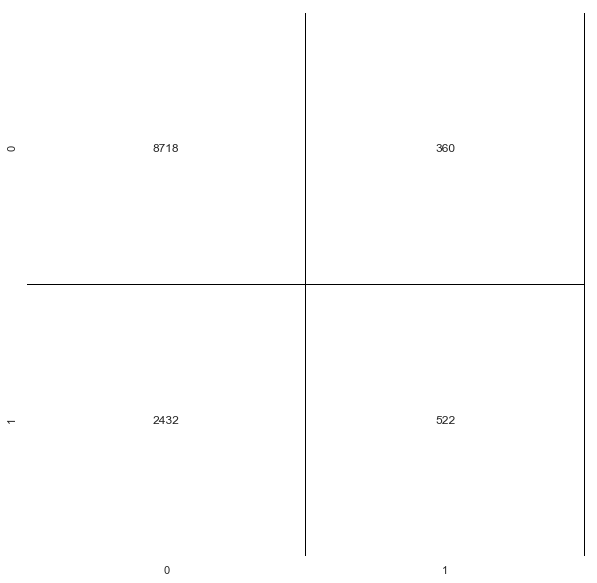

In [24]:
from sklearn.metrics import confusion_matrix
#y_pred_tree = [1 if x > 0.5 else 0 for x in y_pred_tree]
confusion_matrix_tree = confusion_matrix(y_test, y_pred_tree)
with sns.axes_style('white'):
    sns.heatmap(confusion_matrix_tree,
                cbar=False,
                linecolor='black',
                linewidth = 0.5,
                square=False,
                annot=True,
                fmt='g',
                cmap=ListedColormap(['white']),
                linewidths=0.5)

In [25]:
print("Accuracy is {:.2f}".format(accuracy_tree),"%")

Accuracy is 76.80 %


### KNN

In [26]:
scaler = StandardScaler()
scaler.fit(X_train.astype(float))

X_train_knn = scaler.transform(X_train.astype(float))
X_test_knn = scaler.transform(X_test.astype(float))
classifier = KNeighborsClassifier(n_neighbors=5)
classifier.fit(X_train_knn, y_train)
y_pred_knn = classifier.predict(X_test_knn)

C:\Users\prave\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  import sys


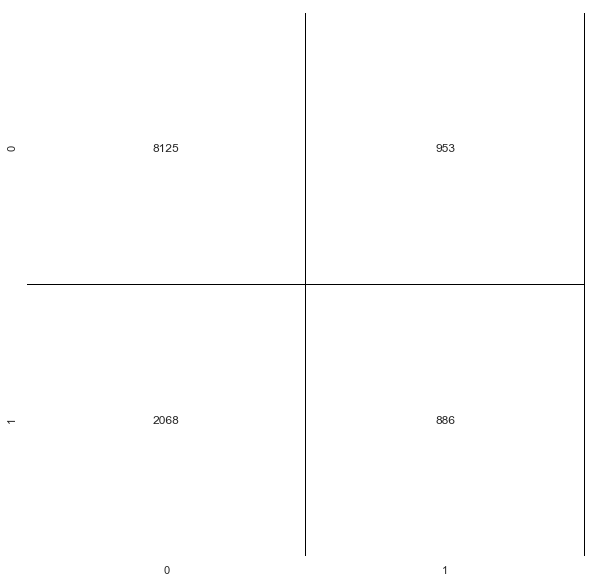

In [27]:
from sklearn.metrics import confusion_matrix
# y_pred_tree = [1 if x > 0.5 else 0 for x in y_pred_tree]
confusion_matrix_knn = confusion_matrix(y_test, y_pred_knn)
with sns.axes_style('white'):
    sns.heatmap(confusion_matrix_knn,
                cbar=False,
                linecolor='black',
                linewidth = 0.5,
                square=False,
                annot=True,
                fmt='g',
                cmap=ListedColormap(['white']),
                linewidths=0.5)

In [28]:
accuracy_knn = accuracy_score(y_test,y_pred_knn)*100
print('Accuracy of logistic regression classifier on test set: {:.2f} %'.format(accuracy_knn))

Accuracy of logistic regression classifier on test set: 74.89 %


### Random Forest

In [29]:
clf=RandomForestClassifier(n_estimators=50) #Create a Gaussian Classifier
clf.fit(X_train,y_train) #Train the model using the training sets y_pred=clf.predict(X_test)
y_pred_RandomForest=clf.predict(X_test)

C:\Users\prave\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


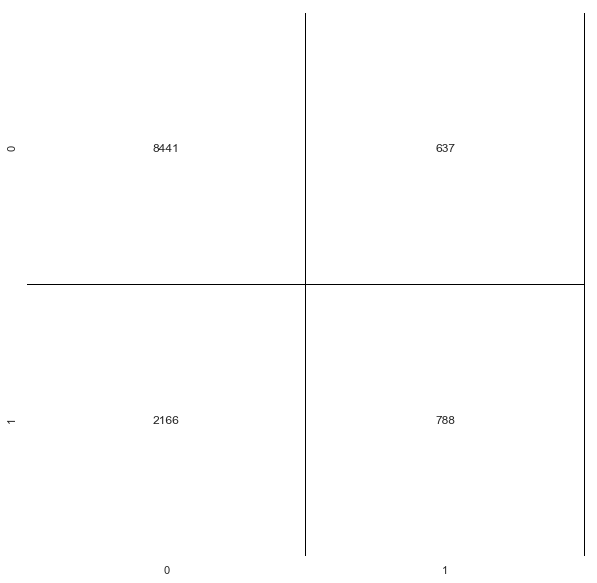

In [30]:
from sklearn.metrics import confusion_matrix
# y_pred_tree = [1 if x > 0.5 else 0 for x in y_pred_tree]
confusion_matrix_rf = confusion_matrix(y_test, y_pred_RandomForest)
with sns.axes_style('white'):
    sns.heatmap(confusion_matrix_rf,
                cbar=False,
                linecolor='black',
                linewidth = 0.5,
                square=False,
                annot=True,
                fmt='g',
                cmap=ListedColormap(['white']),
                linewidths=0.5)

In [31]:
accuracy_rf = accuracy_score(y_test,y_pred_RandomForest)*100
print("Accuracy is {:.2f}".format(accuracy_rf),"%")
# print("Accuracy: ",accuracy_score(y_test, y_pred_RandomForest))

Accuracy is 76.70 %


### XGBoost

In [32]:
model = XGBClassifier()
model.fit(X_train.astype(float), y_train)
y_pred_XGBoost=model.predict(X_test.astype(float))

C:\Users\prave\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:219: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\prave\Anaconda3\lib\site-packages\sklearn\preprocessing\label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


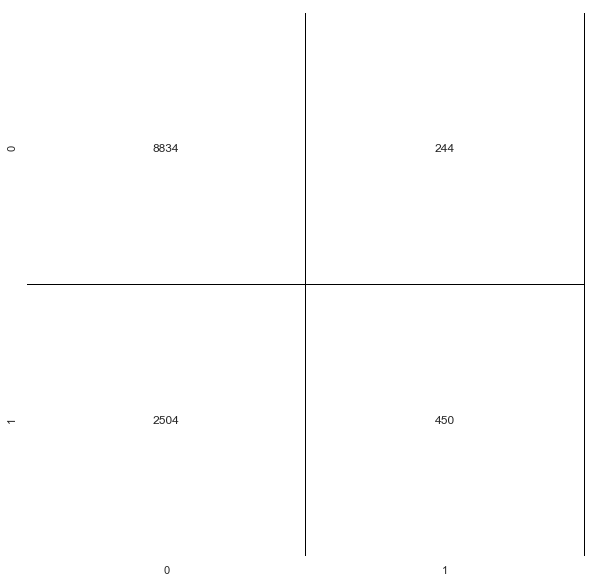

In [33]:
from sklearn.metrics import confusion_matrix
# y_pred_tree = [1 if x > 0.5 else 0 for x in y_pred_tree]
confusion_matrix_xgboost = confusion_matrix(y_test, y_pred_XGBoost)
with sns.axes_style('white'):
    sns.heatmap(confusion_matrix_xgboost,
                cbar=False,
                linecolor='black',
                linewidth = 0.5,
                square=False,
                annot=True,
                fmt='g',
                cmap=ListedColormap(['white']),
                linewidths=0.5)

In [34]:
accuracy_xgboost = accuracy_score(y_test,y_pred_XGBoost)*100
print("Accuracy is {:.2f}".format(accuracy_xgboost),"%")
# print("Accuracy: ",accuracy_score(y_test, y_pred_RandomForest))

Accuracy is 77.16 %


### Model Comparison

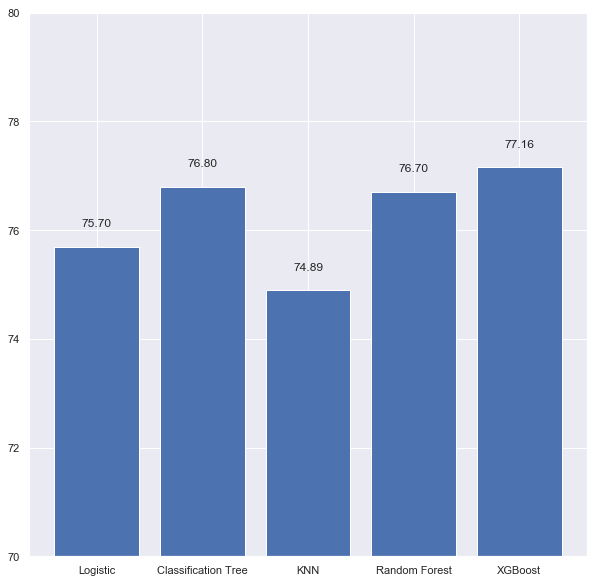

In [35]:
models   = ['Logistic','Classification Tree','KNN','Random Forest','XGBoost']
accuracy = [accuracy_logreg, accuracy_tree, accuracy_knn, accuracy_rf,accuracy_xgboost]
#dict_models = dict(zip(models,accuracy))
#df_models = pd.DataFrame.from_dict(dict_models, orient='index')
#df_models.sort_values(by=0).plot(kind='bar', figsize = (8,8), legend=False, ylim=(70,80))

plt.bar(models,accuracy)
for x,y in zip(models,accuracy):

    label = "{:.2f}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,20), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

fig_size = plt.rcParams["figure.figsize"]

x1,x2,y1,y2 = plt.axis()
plt.axis((x1,x2,70,80))

plt.show()